# Importing necessary libraries

In [ ]:
!pip install tensorflow tensorflow-addons Pillow

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import math
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Rescaling
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

import torch
import torchvision.models as models
from torchvision import transforms

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Loading the dataset
1. Add the training dataset's zip file to your google drive.
2. Mount the google drive to the colab notebook by running the first code setion.
3. Unzip the file to the local environment by running the second code section. (Set the path to the dataset accordingly)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\ Drive/archive.zip

# Preprocessing the data

1. Preprocess the images by resizing them to 160x160 pixels for the training data. We will normalize the images in the model itself because the runtime keeps crashing.
2. Split the data into training, validation and testing set.

## Getting the paths to the dataset

In [5]:
# Getting paths to training and testing images.
train_fol = '/content/Human Action Recognition/train'
test_fol = '/content/Human Action Recognition/test'

# Getting paths to csv files.
train_csv = '/content/Human Action Recognition/Training_set.csv'
test_csv = '/content/Human Action Recognition/Testing_set.csv'

In [6]:
# Store the csv file as a Pandas dataframe.
train_data = pd.read_csv(train_csv)

# Get the columns of the dataframe.
train_filenames = train_data['filename']
train_labels = train_data['label']

## Preprocessing the images

In [7]:
# Store the preprocessed arrays of images.
resized_images = []

# Go through each image and store the corresponding array.
for i in range(len(train_data)):
  img = Image.open(os.path.join(train_fol + "/" + train_filenames[i])) # Get the image.
  # Split the image into its red, green and blue components and store it in an array.
  resized_images.append(np.asarray(img.resize((160, 160)))) # Convert and store the image.

# Convert the array into a Numpy array.
x_train = np.asarray(resized_images)

In [8]:
# Convert the label to a Numpy array.
y_train = to_categorical(np.asarray(train_data['label'].factorize()[0]))

In [9]:
# Spliting the training set into training, testing and validation set for custom model.
xc_train, xc_test, yc_train, yc_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
xc_train, xc_val, yc_train, yc_val = train_test_split(xc_train, yc_train, test_size=0.2, random_state=42)

# Custom CNN Model

## Making model

In [10]:
# Creating our own CNN model.
# Using Batch Normalization makes the neural network faster. It is used to
# substitute the process of image normalization to bypass the errors caused by
# the limitations on the resources.
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(160, 160, 3), kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [11]:
# Compiling the model.
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 160, 160, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 80, 80, 64)        256       
 chNormalization)                                                
                                                        

In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Data Augmentation
data_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

In [13]:
# Training the model with data augmentation
custom_model.fit(data_gen.flow(xc_train, yc_train, batch_size=16), epochs=50, validation_data=(xc_val, yc_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
567/567 [==============================] - 59s 90ms/step - loss: 3.1577 - accuracy: 0.1189 - val_loss: 11.7945 - val_accuracy: 0.0886 - lr: 0.0010
Epoch 2/50
567/567 [==============================] - 49s 87ms/step - loss: 2.8044 - accuracy: 0.1601 - val_loss: 2.7437 - val_accuracy: 0.1861 - lr: 0.0010
Epoch 3/50
567/567 [==============================] - 49s 87ms/step - loss: 2.6301 - accuracy: 0.1867 - val_loss: 3.4144 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 4/50
567/567 [==============================] - 50s 89ms/step - loss: 2.5574 - accuracy: 0.1991 - val_loss: 3.5116 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 5/50
567/567 [==============================] - 49s 87ms/step - loss: 2.4393 - accuracy: 0.2283 - val_loss: 2.3480 - val_accuracy: 0.2509 - lr: 0.0010
Epoch 6/50
567/567 [==============================] - 49s 87ms/step - loss: 2.4601 - accuracy: 0.2224 - val_loss: 2.4412 - val_accuracy: 0.2407 - lr: 0.0010
Epoch 7/50
567/567 [==============================] - 49s

## Model predictions

In [14]:
# Function to convert an image to Numpy array.
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((160,160)))

In [15]:
def predict(input_model, test_image):

    # Predict the class
    result = input_model.predict(np.asarray([read_img(test_image)]))

    # Extract the prediction
    itemindex = np.where(result == np.max(result))
    prediction = itemindex[1][0]
    print("Probability: " + str(np.max(result) * 100) + "%\nPredicted class: ", prediction)

    # Display the image and prediction
    plt.imshow(read_img(test_image))
    plt.title(f"Prediction: {prediction}")
    plt.show()

1/1 [==============================] - 0s 383ms/step
Probability: 27.968597412109375%
Predicted class:  1


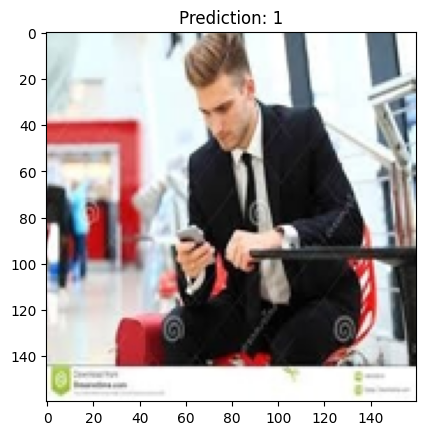

In [16]:
predict(custom_model, '/content/Human Action Recognition/test/Image_5371.jpg')

1/1 [==============================] - 0s 20ms/step
Probability: 25.656315684318542%
Predicted class:  4


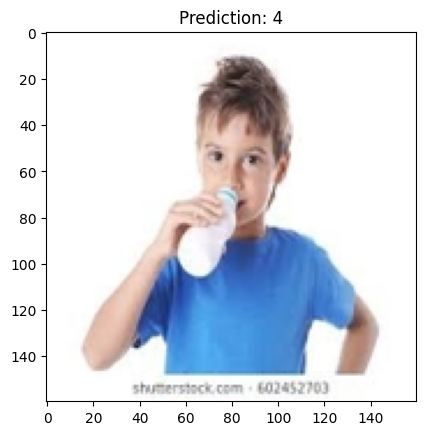

In [17]:
predict(custom_model, '/content/Human Action Recognition/test/Image_101.jpg')

# Pre-trained Models

## 1. EfficientNetB7

### Making model

In [ ]:
efficientnet = Sequential()

model = tf.keras.applications.EfficientNetB7( include_top=False,
                                              input_shape=(160,160,3),
                                              pooling ="avg",classes=15,
                                              weights="imagenet" )

for layer in model.layers:
    layer.trainable=False

efficientnet.add(model)
efficientnet.add(Flatten())
efficientnet.add(Dense(512,activation="relu"))
efficientnet.add(Dense(15,activation="softmax"))

In [25]:
efficientnet.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
efficientnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1311232   
                                                                 
 dense_3 (Dense)             (None, 15)                7695      
                                                                 
Total params: 65416614 (249.54 MB)
Trainable params: 1318927 (5.03 MB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [26]:
history = efficientnet.fit(xc_train, yc_train, batch_size=16, epochs=15, validation_data=(xc_val, yc_val))

Epoch 1/15
567/567 [==============================] - 103s 146ms/step - loss: 1.3019 - accuracy: 0.5880 - val_loss: 1.1694 - val_accuracy: 0.6318
Epoch 2/15
567/567 [==============================] - 74s 131ms/step - loss: 0.8691 - accuracy: 0.7175 - val_loss: 1.1237 - val_accuracy: 0.6455
Epoch 3/15
567/567 [==============================] - 74s 131ms/step - loss: 0.6160 - accuracy: 0.7992 - val_loss: 1.1876 - val_accuracy: 0.6512
Epoch 4/15
567/567 [==============================] - 74s 131ms/step - loss: 0.4215 - accuracy: 0.8625 - val_loss: 1.2509 - val_accuracy: 0.6468
Epoch 5/15
567/567 [==============================] - 74s 131ms/step - loss: 0.2936 - accuracy: 0.9053 - val_loss: 1.3559 - val_accuracy: 0.6578
Epoch 6/15
567/567 [==============================] - 74s 131ms/step - loss: 0.2007 - accuracy: 0.9384 - val_loss: 1.4789 - val_accuracy: 0.6424
Epoch 7/15
567/567 [==============================] - 74s 131ms/step - loss: 0.1656 - accuracy: 0.9492 - val_loss: 1.5464 - val_a

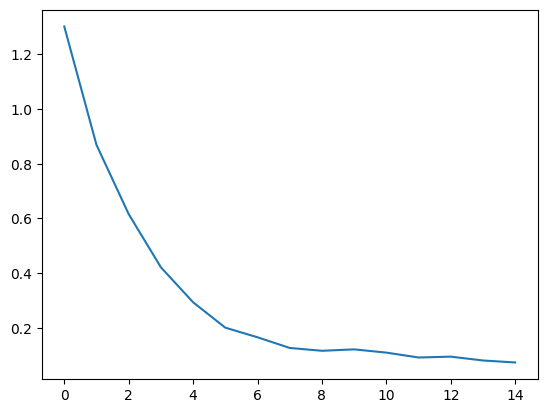

In [27]:
losses = history.history["loss"]
plt.plot(losses)

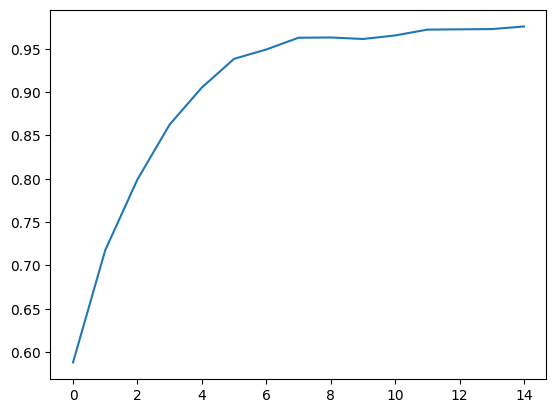

In [28]:
acc = history.history['accuracy']
plt.plot(acc)

### Model predictions

1/1 [==============================] - 7s 7s/step
Probability: 96.66770696640015%
Predicted class:  0


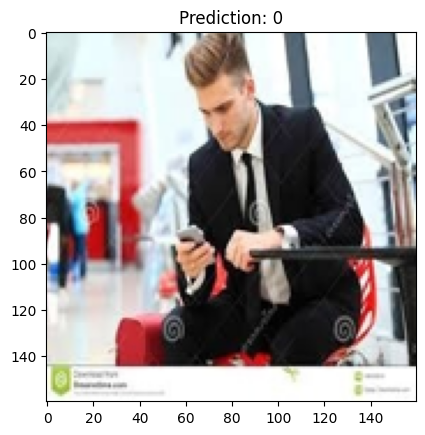

In [29]:
predict(efficientnet, '/content/Human Action Recognition/test/Image_5371.jpg')

1/1 [==============================] - 0s 47ms/step
Probability: 99.99597072601318%
Predicted class:  4


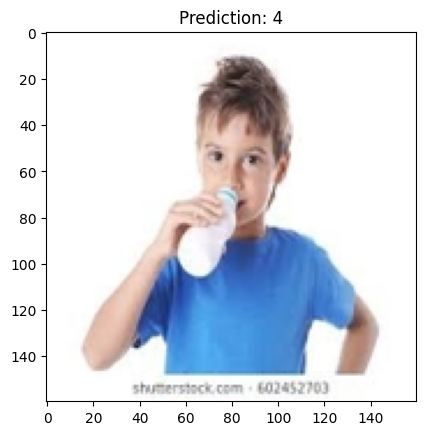

In [30]:
predict(efficientnet, '/content/Human Action Recognition/test/Image_101.jpg')

## 2. ResNet50

### Making model

In [ ]:
# Intializing a Sequential model to
resnet50 = Sequential()

# Getting a pretrained ResNet50 model.
pretrained_resnet50 = tf.keras.applications.ResNet50(
  include_top=False,
  input_shape=(160, 160, 3),
  pooling='avg',
  classes=15, # Initialized the number of classes in the dataset
  weights='imagenet'
)

# Freezing the weights of the pretrained model to avoid retraining
for layer in pretrained_resnet50.layers:
  layer.trainable = False

# Adding the pretrained model and additional layers to the Sequential model
resnet50.add(pretrained_resnet50)
# resnet50.add(Flatten())
# resnet50.add(Dense(512, activation='relu'))
resnet50.add(Dense(15, activation='softmax')) # Predicts one of 15 labels

In [37]:
# Compiling the model
resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 15)                30735     
                                                                 
Total params: 23618447 (90.10 MB)
Trainable params: 30735 (120.06 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [38]:
# Training the model
history = resnet50.fit(xc_train, yc_train, batch_size=16, epochs=15, validation_data=(xc_val, yc_val))

Epoch 1/15
567/567 [==============================] - 28s 43ms/step - loss: 1.7325 - accuracy: 0.4776 - val_loss: 1.5213 - val_accuracy: 0.5432
Epoch 2/15
567/567 [==============================] - 22s 40ms/step - loss: 1.2452 - accuracy: 0.6096 - val_loss: 1.4788 - val_accuracy: 0.5560
Epoch 3/15
567/567 [==============================] - 22s 40ms/step - loss: 1.0509 - accuracy: 0.6522 - val_loss: 1.4230 - val_accuracy: 0.5754
Epoch 4/15
567/567 [==============================] - 22s 39ms/step - loss: 0.9251 - accuracy: 0.7021 - val_loss: 1.4596 - val_accuracy: 0.5595
Epoch 5/15
567/567 [==============================] - 22s 39ms/step - loss: 0.8235 - accuracy: 0.7262 - val_loss: 1.4436 - val_accuracy: 0.5820
Epoch 6/15
567/567 [==============================] - 22s 39ms/step - loss: 0.7356 - accuracy: 0.7521 - val_loss: 1.4906 - val_accuracy: 0.5780
Epoch 7/15
567/567 [==============================] - 22s 39ms/step - loss: 0.6740 - accuracy: 0.7790 - val_loss: 1.5601 - val_accuracy:

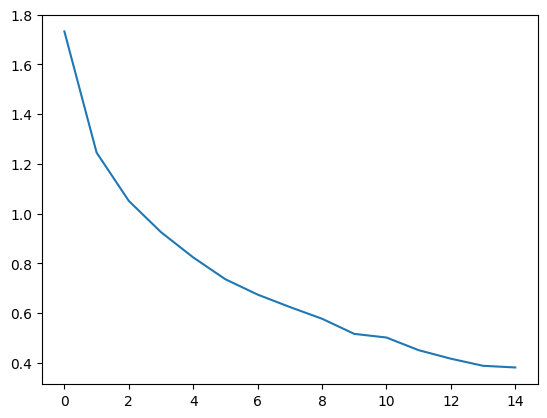

In [39]:
losses = history.history["loss"]
plt.plot(losses)

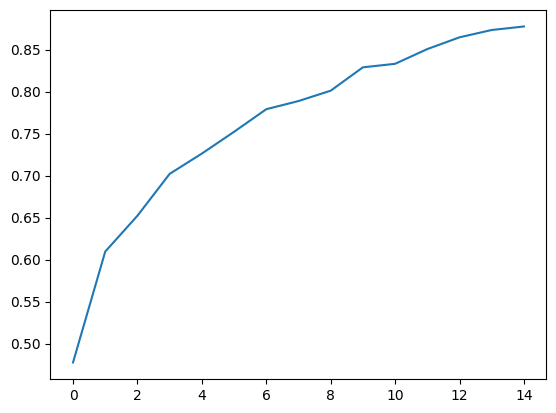

In [40]:
acc = history.history['accuracy']
plt.plot(acc)

### Model predictions

1/1 [==============================] - 2s 2s/step
Probability: 77.22901105880737%
Predicted class:  8


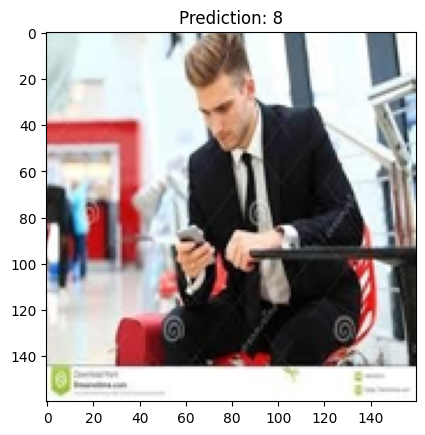

In [41]:
predict(resnet50, '/content/Human Action Recognition/test/Image_5371.jpg')

1/1 [==============================] - 0s 34ms/step
Probability: 57.932090759277344%
Predicted class:  8


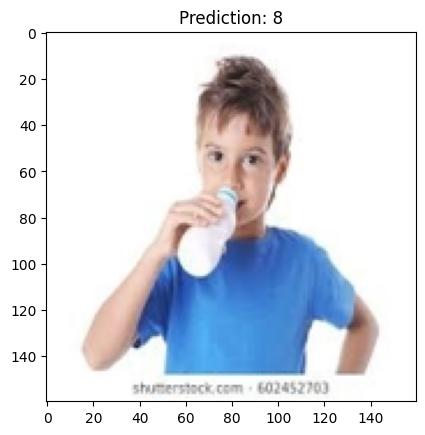

In [42]:
predict(resnet50, '/content/Human Action Recognition/test/Image_101.jpg')

# Evaluation

## 1. Evalutation Metrics

In [43]:
def evaluate_model(model, x_test, y_test):
    # Predictions
    y_pred = model.predict(xc_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(yc_test, axis=1)

    # Metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    return accuracy, report, conf_matrix

In [44]:
models = [custom_model, efficientnet, resnet50]
model_names = ["Custom CNN Model", "EfficientNet Model", "ResNet50 Model"]

In [45]:
# Evaluate all models
results = {}
for model, name in zip(models, model_names):
    accuracy, report, conf_matrix = evaluate_model(model, xc_test, yc_test)
    results[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

40/40 [==============================] - 4s 54ms/step


In [46]:
# Print results
for name, metrics in results.items():
    print(f"{name} - Accuracy: {metrics['accuracy']}\n")
    print(f"{name} - Classification Report:\n{metrics['classification_report']}\n")

Custom CNN Model - Accuracy: 0.4658730158730159

Custom CNN Model - Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.37      0.35        78
           1       0.36      0.54      0.43        80
           2       0.35      0.39      0.37        76
           3       0.61      0.59      0.60        73
           4       0.53      0.24      0.33        75
           5       0.39      0.39      0.39        77
           6       0.53      0.56      0.55        86
           7       0.48      0.87      0.62        92
           8       0.26      0.26      0.26        87
           9       0.60      0.50      0.54        92
          10       0.70      0.78      0.74        74
          11       0.65      0.42      0.51       106
          12       0.33      0.36      0.34        94
          13       0.55      0.62      0.58        84
          14       0.56      0.10      0.18        86

    accuracy                           0.47

## 2. Confusion Matrix

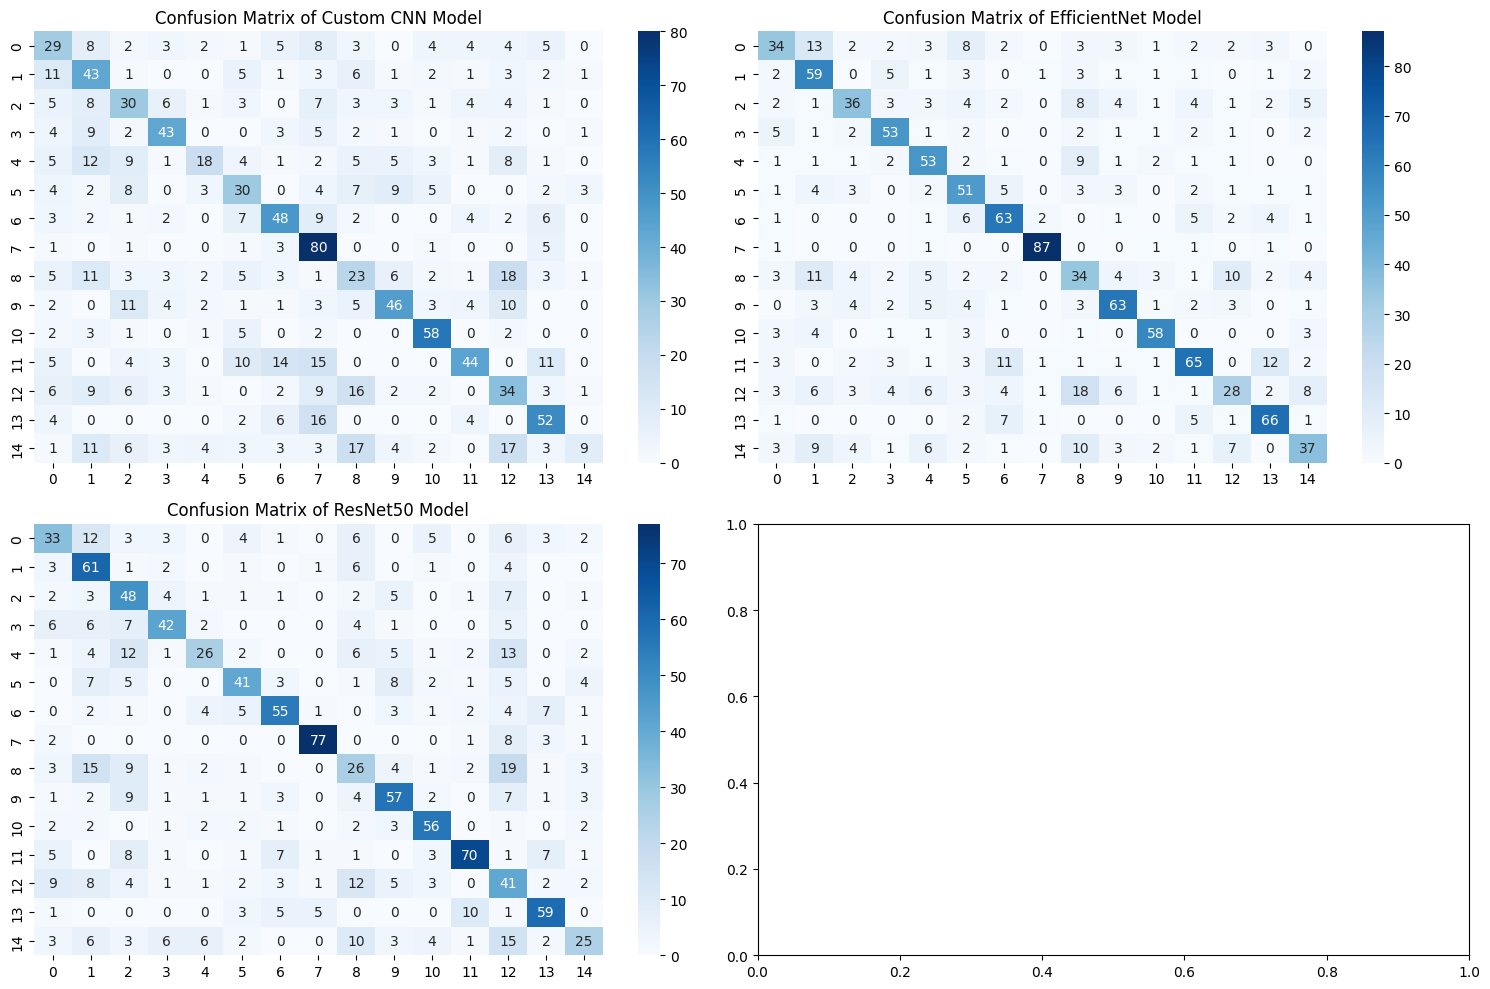

In [49]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, (name, metrics) in zip(axes.flatten(), results.items()):
    sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", ax=ax, cmap='Blues')
    ax.set_title(f"Confusion Matrix of {name}")
plt.tight_layout()
plt.show()

## 3. ROC Curve

40/40 [==============================] - 2s 57ms/step


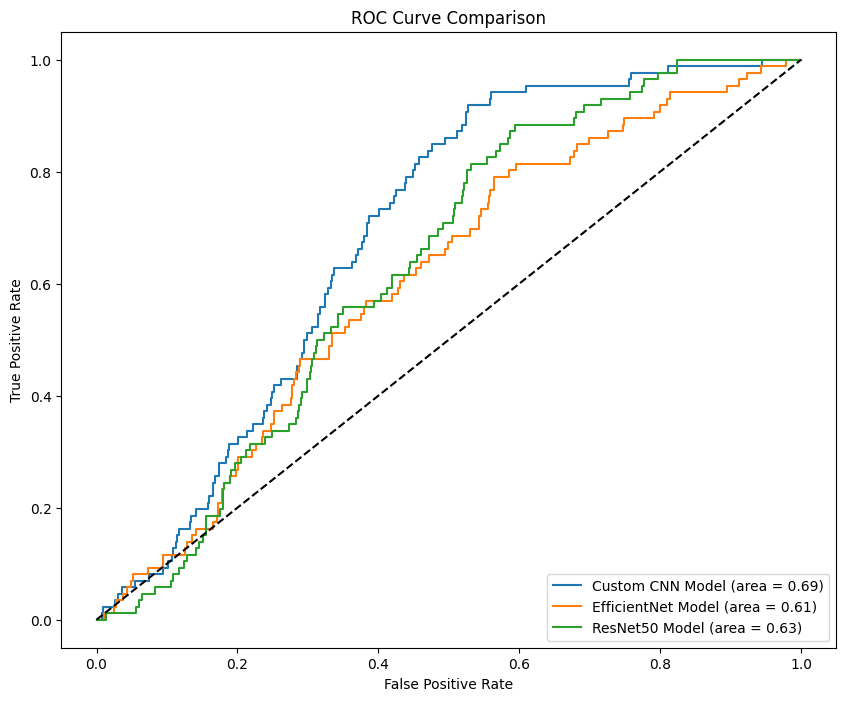

In [50]:
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curve(models, xc_test, yc_test):
    plt.figure(figsize=(10, 8))
    lb = LabelBinarizer()
    yc_test_binarized = lb.fit_transform(yc_test)

    for model, name in zip(models, model_names):
        y_probs = model.predict(xc_test)
        # for i in range(yc_test_binarized.shape[1]):
        # y_true_encoded = np.argmax(yc_test, axis=1)
        fpr, tpr, thresholds = roc_curve(yc_test_binarized[:, yc_test_binarized.shape[1] - 1], y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(models, xc_test, yc_test)